SKRIV MODELLEN MATEMATISK

Overvej GMM estimation

Differentier model udvidelsen


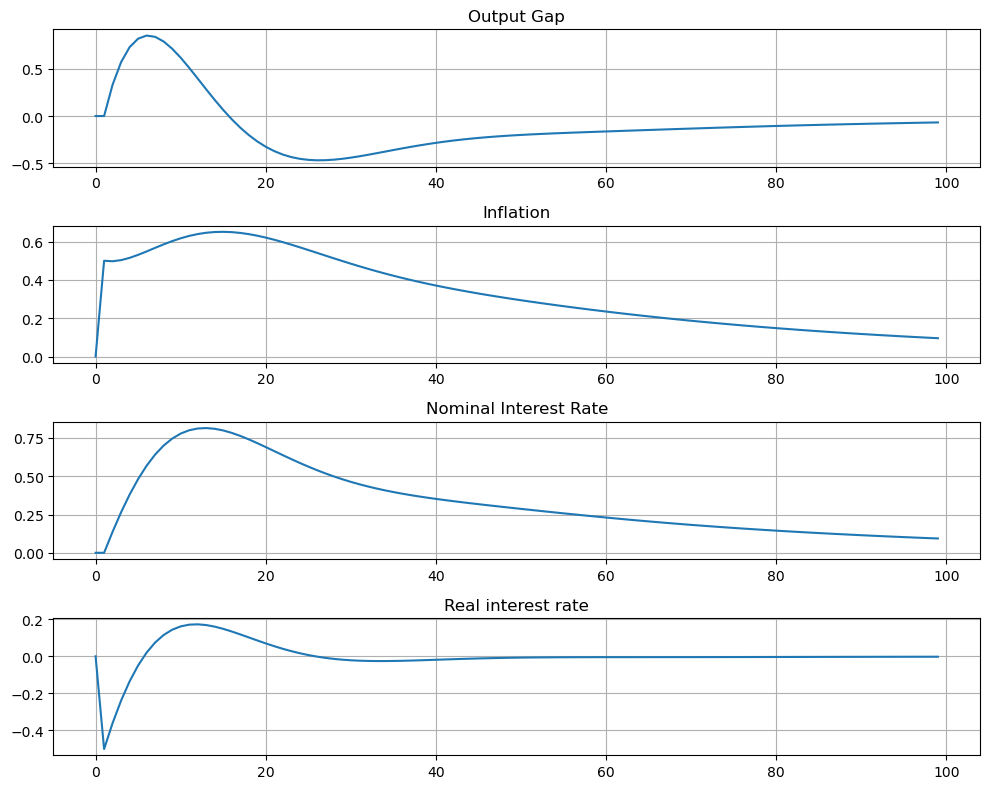

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.filters.hp_filter import hpfilter
from ModelProject import *

data = pd.read_csv('GDP.csv',delimiter=';', encoding='utf-8')

data['GDP'] = data['GDP'].str.replace(',', '.').astype(float)
data['Inflation'] = data['Inflation'].str.replace(',', '.').astype(float)
data['InterestRate'] = data['InterestRate'].str.replace(',', '.').astype(float)
#print(data)
# Calculate the output gap using Hodrick-Prescott filter
cycle, trend = hpfilter(data['GDP'], lamb=1600)  # lambda=1600 for quarterly data
data['OutputGap'] = cycle

#data['Inflation'] = data['Inflation'] / 100  # Assuming the data is in percentage form
#data['InterestRate'] = data['InterestRate'] / 100

# Model Parameters
beta = 0.995    # Discount factor
sigma = 1.5     # Elasticity of intertemporal substitution
kappa = 0.025   # Slope of the Phillips curve
phi_pi = 1.1    # Taylor rule coefficient for inflation
phi_y = 0.3     # Taylor rule coefficient for output
rho = 0.75      # Interest rate smoothing

# Shocks
epsilon_pi = np.zeros(T)   # No shock to inflation
epsilon_y = np.zeros(T)    # No shock to IS curve

# Time period
T = 100
shock_size = 0.5  # Size of the monetary policy shock

# Initialize arrays
pi = np.zeros(T)  # Inflation
y = np.zeros(T)   # Output gap
i = np.zeros(T)   # Nominal interest rate
r_n = np.zeros(T)          # Natural rate of interest (assumed to be constant at 0)
#r_n = 0

# Introduce a shock at time t = 5
epsilon_i = np.zeros(T)  # Monetary policy shock
epsilon_pi[1] = shock_size


# Simulate the model
for t in range(1, T):
    y[t] = y[t-1] - (1/sigma) * (i[t-1] - pi[t-1] - r_n[t]) + epsilon_y[t]
    # Taylor rule
    i[t] = rho * i[t-1] + (1 - rho) * (phi_pi * pi[t-1] + phi_y * y[t-1]) + epsilon_i[t]
    # New Keynesian Phillips Curve
    pi[t] = beta * pi[t-1] + kappa * y[t-1] + epsilon_pi[t]

    r_n[t]=i[t]-pi[t]
    # Dynamic IS Equation
    

# Plotting
plt.figure(figsize=(10, 8))
plt.subplot(411)
plt.plot(y, label='Output Gap')
plt.title('Output Gap')
plt.grid(True)

plt.subplot(412)
plt.plot(pi, label='Inflation')
plt.title('Inflation')
plt.grid(True)

plt.subplot(413)
plt.plot(i, label='Nominal Interest Rate')
plt.title('Nominal Interest Rate')
plt.grid(True)

plt.subplot(414)
plt.plot(r_n, label='Real interest rate')
plt.title('Real interest rate')
plt.grid(True)

plt.tight_layout()
plt.show()


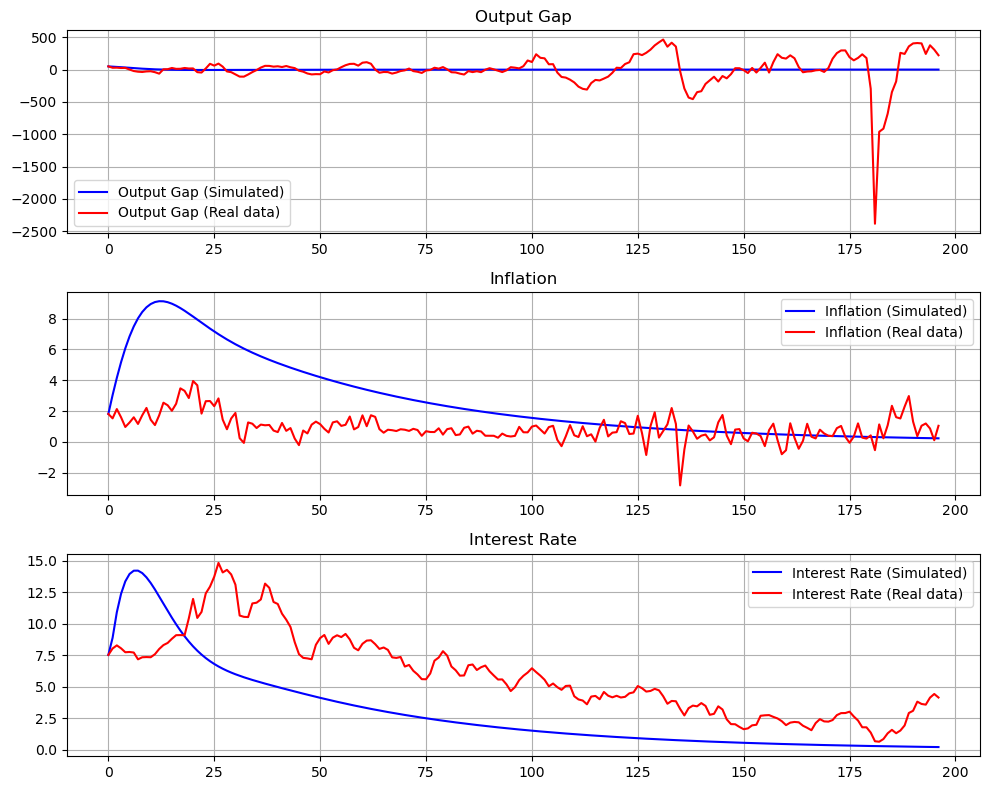

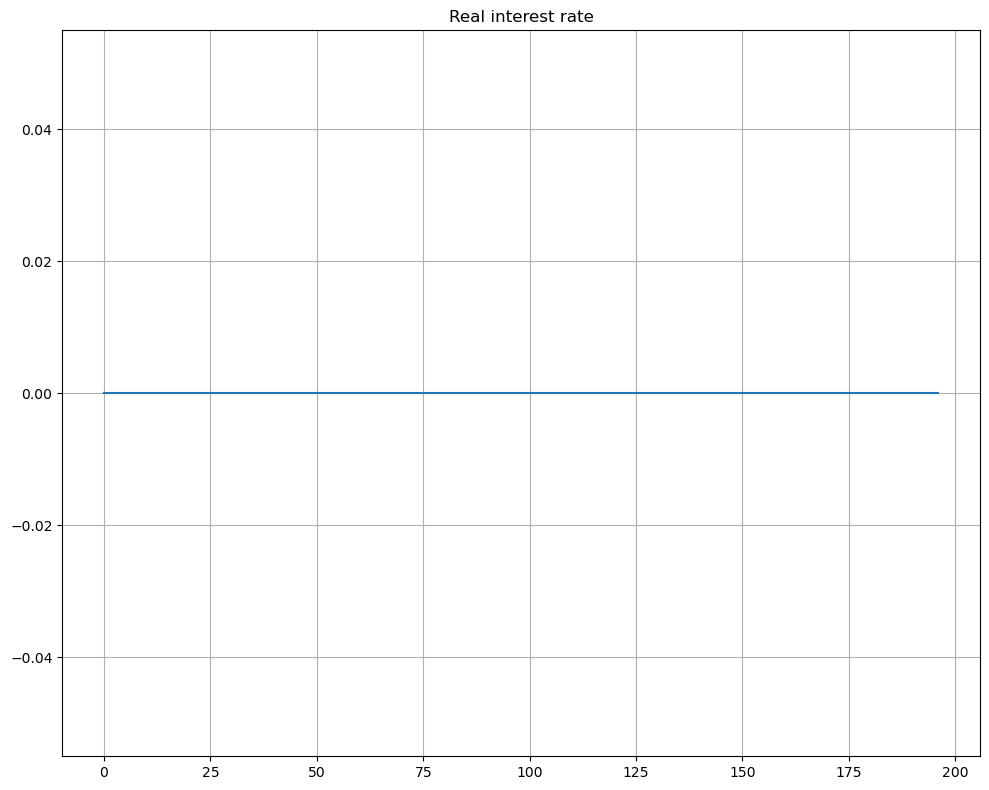

In [79]:
# Use the data directly in the model
pi = data['Inflation'].values
y = data['OutputGap'].values
i = data['InterestRate'].values

# Simulation parameters
T = len(data)  # Length of the dataset

# Arrays for simulation (overwrite with actual data for starting values)
pi = np.zeros(T)
y = np.zeros(T)
i = np.zeros(T)
r_n = np.zeros(T) 
epsilon_i = np.zeros(T)
#r_n=0
pi[0] = data['Inflation'].iloc[0]
y[0] = data['OutputGap'].iloc[0]
i[0] = data['InterestRate'].iloc[0]

shock_size=-1
epsilon_i[1] = shock_size

# Simulate the model (continue from the first value)
for t in range(1, T):
    r_n[t]=i[t]-pi[t]
    y[t] = y[t-1] - (1/sigma) * (i[t-1] - pi[t-1]-r_n[t])  # add error terms as needed
    pi[t] = beta * pi[t-1] + kappa * y[t-1]  # add error terms as needed
    i[t] = rho * i[t-1] + (1 - rho) * (phi_pi * pi[t] + phi_y * y[t]) + epsilon_i[t] # add error terms as needed
    
    
    


# Plotting the simulation results alongside actual data
fig, axes = plt.subplots(3, 1, figsize=(10, 8))
time = np.arange(T)
titles = ['Output Gap', 'Inflation', 'Interest Rate']
for ax, real_data, sim_data, title in zip(axes, [y, pi, i], [data['OutputGap'], data['Inflation'], data['InterestRate']], titles):
    ax.plot(time, real_data, label=f'{title} (Simulated)', color='blue')
    ax.plot(time, sim_data, label=f'{title} (Real data)', color='red')
    ax.set_title(title)
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))

plt.plot(r_n, label='Real interest rate')
plt.title('Real interest rate')
plt.grid(True)

plt.tight_layout()
plt.show()

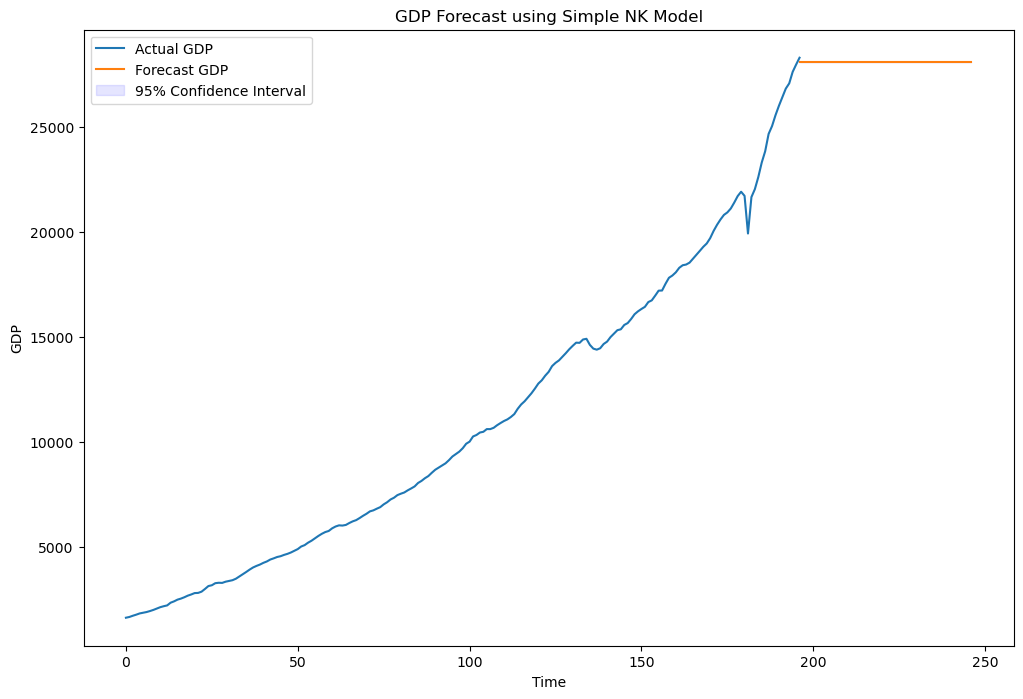

In [89]:
# Convert trend to numpy array to prevent index issues
trend = trend.values

# Data length and forecast horizon
historical_len = len(data)
forecast_horizon = 50
total_len = historical_len + forecast_horizon

# Initialize arrays for historical + forecast period
pi = np.zeros(total_len)  # Inflation
y = np.zeros(total_len)   # Output gap
i = np.zeros(total_len)   # Nominal interest rate
r_n = np.zeros(total_len)  # Assuming natural rate of interest is zero for simplicity

# Set initial conditions from historical data
y[:historical_len] = cycle  # assuming cycle from HP filter represents output gap

# Model parameters (example values, replace with your estimated parameters)
beta = 0.995
sigma = 1.5
kappa = 0.025
phi_pi = 1.1
phi_y = 0.3
rho = 0.75

# Simulate the model forward
for t in range(1, total_len):
    r_n[t]=i[t]-pi[t]
    i[t] = rho * i[t-1] + (1 - rho) * (phi_pi * pi[t-1] + phi_y * y[t-1])
    pi[t] = beta * pi[t-1] + kappa * y[t-1]
    y[t] = y[t-1] - (1/sigma) * (i[t-1] - pi[t-1] - r_n[t])

# Adjust plot range
forecast_range = np.arange(historical_len-1, total_len)  # This is where the forecast starts and ends

# Plot historical data and forecast
plt.figure(figsize=(12, 8))
plt.plot(np.arange(historical_len), data['GDP'], label='Actual GDP')
plt.plot(forecast_range, trend[historical_len-1:total_len] + y[historical_len-1:total_len], label='Forecast GDP')
plt.fill_between(forecast_range, (trend[historical_len-1:total_len] + y[historical_len-1:total_len] - 1.96), (trend[historical_len-1:total_len] + y[historical_len-1:total_len] + 1.96), color='b', alpha=0.1, label='95% Confidence Interval')
plt.legend()
plt.title('GDP Forecast using Simple NK Model')
plt.xlabel('Time')
plt.ylabel('GDP')
plt.show()

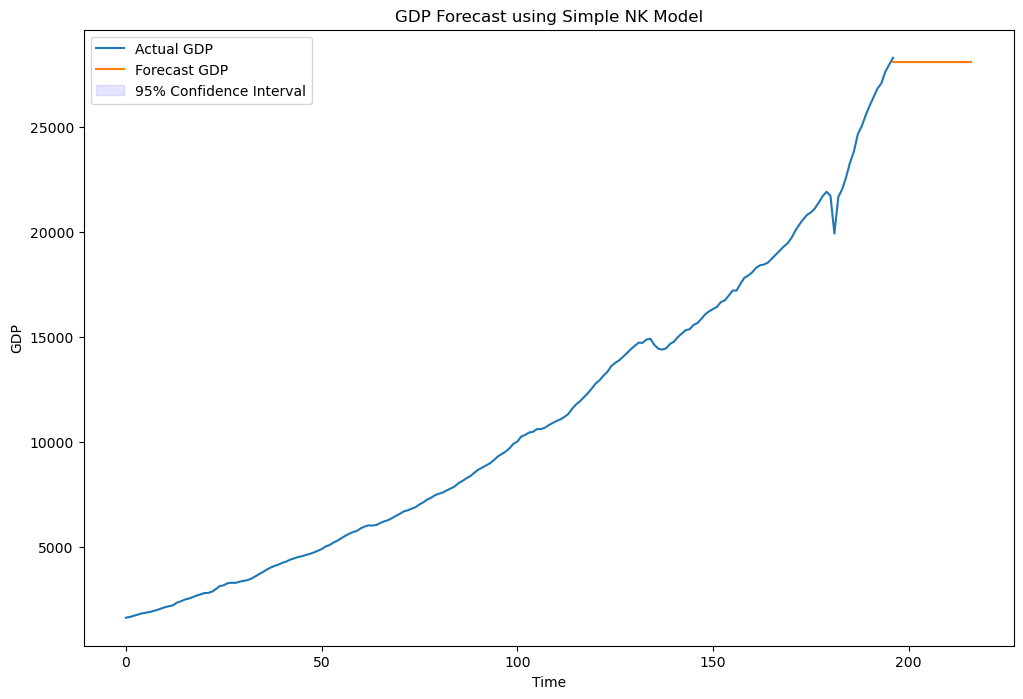

In [94]:
# Hodrick-Prescott filter to get the cyclical component of GDP
cycle, trend = hpfilter(data['GDP'], lamb=1600)

# Convert trend to numpy array to prevent index issues
trend = trend.values

# Data length and forecast horizon
historical_len = len(data)
forecast_horizon = 20
total_len = historical_len + forecast_horizon

# Initialize arrays for historical + forecast period
pi = np.zeros(total_len)  # Inflation
y = np.zeros(total_len)   # Output gap
i = np.zeros(total_len)   # Nominal interest rate
r_n = np.zeros(total_len)  # Natural rate of interest is assumed to be a constant for simplicity

# Set initial conditions from historical data
y[:historical_len] = cycle  # assuming cycle from HP filter represents output gap

# Model parameters (example values, replace with your estimated parameters)
beta = 0.995
sigma = 1.5
kappa = 0.025
phi_pi = 1.1
phi_y = 0.3
rho = 0.75

# Initialize arrays for historical + forecast period
pi[0] = data['Inflation'].iloc[-1]  # Start with last known inflation rate if available
i[0] = data['InterestRate'].iloc[-1]  # Start with last known interest rate if available
y[:historical_len] = cycle  # Assuming cycle from HP filter represents output gap

# Continue with the simulation
for t in range(1, total_len):
    r_n[t]=i[t]-pi[t]
    i[t] = rho * i[t-1] + (1 - rho) * (phi_pi * pi[t-1] + phi_y * y[t-1])
    pi[t] = beta * pi[t-1] + kappa * y[t-1]
    y[t] = y[t-1] - (1/sigma) * (i[t-1] - pi[t-1] - r_n[t-1])

# Adjust plot range
forecast_range = np.arange(historical_len-1, total_len)  # This is where the forecast starts and ends

# Plot historical data and forecast
plt.figure(figsize=(12, 8))
plt.plot(np.arange(historical_len), data['GDP'], label='Actual GDP')
plt.plot(forecast_range, trend[historical_len-1:total_len] + y[historical_len-1:total_len], label='Forecast GDP')
plt.fill_between(forecast_range, (trend[historical_len-1:total_len] + y[historical_len-1:total_len] - 1.96), (trend[historical_len-1:total_len] + y[historical_len-1:total_len] + 1.96), color='b', alpha=0.1, label='95% Confidence Interval')
plt.legend()
plt.title('GDP Forecast using Simple NK Model')
plt.xlabel('Time')
plt.ylabel('GDP')
plt.show()